# Imports and Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch


two_pi = 2*pi

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, two_pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

# Utility

In [2]:
def class_plot(X_input, aspect=True, title=False, orig=True, save=False):
    X_tsne = TSNE(n_components=2).fit_transform(X_input)
    X_pca = PCA(n_components=2).fit_transform(X_input)
    
    
    markers = ['x', 'o', 'x', 'o']
    colors = ['r', 'b']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    t1, t2 = '(a)', '(b)'
    for i in range(2):
        for j in range(2):
            tmp = X[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax1.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax1.axis('equal')
    ax1.set_title(t1, y= -0.2)
    
    for i in range(2):
        for j in range(2):
            tmp = X_pca[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax2.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax2.axis('equal')
    ax2.set_title(t2, y= -0.2)
    plt.show()

In [9]:
r = [10, 20]
n = [32, 32]
circles = circle_points(r, n)

ally_label = 0
advr_label = 0

X, y_ally, y_advr = [], [], []

for circle in circles:
    pos = circle[np.where(circle[:, 1]> 0)]
    neg = circle[np.where(circle[:, 1]<= 0)]
    X.append(pos)
    X.append(neg)
    y_ally.append([ally_label] * circle.shape[0])
    y_advr.append([advr_label] * pos.shape[0] + [advr_label+1] * neg.shape[0])
    ally_label += 1
    
X = np.concatenate(X, axis=0)
y_ally = np.concatenate(y_ally).reshape(-1, 1)
y_advr = np.concatenate(y_advr).reshape(-1, 1)
X.shape, y_ally.shape, y_advr.shape

((64, 2), (64, 1), (64, 1))

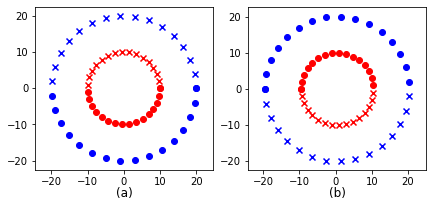

In [4]:
class_plot(X, y_ally, y_advr)

### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

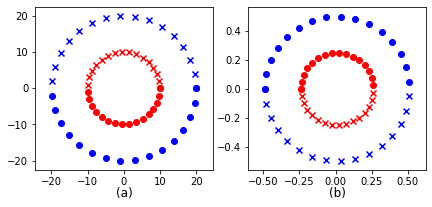

In [6]:
class_plot(X_normalized, y_ally, y_advr)

# PCA

In [11]:
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

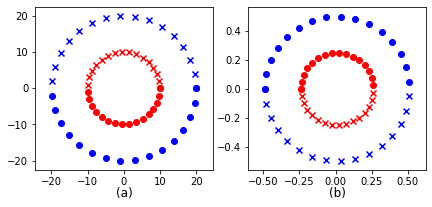

In [8]:
class_plot(X_pca, y_ally, y_advr)

# AutoEncoder

In [14]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        self.hidden_size = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        self.fc11 = torch.nn.Linear(self.hidden_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
        self.fc22 = torch.nn.Linear(self.hidden_size, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.sigmoid(self.fc11(self.sigmoid(self.fc1(x))))

    def decoder(self, y):
        return self.sigmoid(self.fc22(self.sigmoid(self.fc2(y))))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [15]:
auto_encoder = AutoEncoder(
    input_size=X_normalized.shape[1],
    encoding_dim=X_normalized.shape[1], 
    hidden_size=X_normalized.shape[1]*2
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.01)

In [12]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_torch = torch.Tensor(y_advr.reshape(-1, 1))

In [ ]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(10001):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_torch_hat = auto_encoder(X_torch)
    X_torch_hat_valid = auto_encoder(X_torch_valid)
    ae_loss = criterion(X_torch_hat, X_torch)
    ae_loss_valid = criterion(X_torch_hat_valid, X_torch_valid)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_loss_valid.item())
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_loss_valid.item()
    ))
    

In [ ]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss'])
plt.title("autoencoder training")
plt.show()

In [ ]:
X_autoencoded = auto_encoder.encoder(X_torch_valid)

In [ ]:
class_plot(X_autoencoded.detach().numpy(), y_ally_valid, y_advr_valid, title='Autoencoder Representation')

In [ ]:
X_autodecoded = auto_encoder.decoder(X_autoencoded)

In [ ]:
class_plot(X_autodecoded.detach().numpy(), y_ally_valid, y_advr_valid)

# Privacy GAN

In [13]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.tanh(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [14]:
import sys
sys.path.append('../')

In [15]:
from notebook_utils.model_size import SizeEstimator

In [16]:
def train_privacy_gan(alpha, encoding_dimension, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
#     encoding_dimension = X_pca.shape[1]
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*8, 
        output_size=encoding_dimension)
    ally = Ally(
        input_size=encoding_dimension, 
        hidden_size=encoding_dimension*8, 
        output_size=y_ally_torch.shape[1])
    adversary = Adversary(
        input_size=encoding_dimension, 
        hidden_size=encoding_dimension*8, 
        output_size=y_advr_torch.shape[1])
    
    sencd = SizeEstimator(encoder, input_size=(32,2)).estimate_size()[0]
    sally = SizeEstimator(ally, input_size=(32,encoding_dimension)).estimate_size()[0]
    sadvr = SizeEstimator(adversary, input_size=(32,encoding_dimension)).estimate_size()[0]
    sum_ = sencd+sally + sadvr
    print(encoding_dimension, sencd, sadvr, sally, sum_)
    return sum_

    criterion = torch.nn.BCEWithLogitsLoss()
    kldiv = torch.nn.KLDivLoss()
    l1_loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_train = []
    
    encoder.train()
    ally.train()
    adversary.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_torch_hat = adversary(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
        advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
#         advr_loss = (32 - l1_loss(y_advr_torch_hat, y_advr_torch))/32
        encd_loss = ally_loss - alpha * (advr_loss - np.log(0.5))**2
        # Backward pass
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_torch_hat = adversary(X_ganencoded)
            advr_optimizer.zero_grad()
            advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
            advr_loss.backward()
            advr_optimizer.step()
        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_train.append(advr_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_train, 'g')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr train loss',
        ])
        plt.title("GAN training")
        plt.show()            

        return encoder

- maximize the divergence
- no dimensionality reduction here

In [18]:
encoding_dim = []
model_size = []
for dim in range(2, 20000, 1000):
    alpha = 1
    lr_encd = 0.001
    lr_ally = 0.0001
    lr_advr = 0.0001
    n_iter_gan = 1
    d_reps = 1

    # alpha = 0.5
    # lr_encd = 0.01
    # lr_ally = 0.001
    # lr_advr = 0.0001
    # n_iter_gan = 5001
    # d_reps = 2


    encoder = train_privacy_gan(alpha, dim, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)
    encoding_dim.append(dim)
    model_size.append(encoder)

../notebook_utils/model_size.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_ = Variable(torch.FloatTensor(*self.input_size), volatile=True)


2 0.00983428955078125 0.009037017822265625 0.009037017822265625 0.0279083251953125
1002 35.383522033691406 34.738040924072266 34.738040924072266 104.85960388183594
2002 131.79236602783203 130.50220108032227 130.50220108032227 392.79676818847656
3002 289.23636627197266 287.30151748657227 287.30151748657227 863.8394012451172
4002 507.7155227661133 505.13599014282227 505.13599014282227 1517.9875030517578
5002 787.2298355102539 784.0056190490723 784.0056190490723 2355.2410736083984
6002 1127.7793045043945 1123.9104042053223 1123.9104042053223 3375.600112915039
7002 1529.3639297485352 1524.8503456115723 1524.8503456115723 4579.06462097168
8002 1991.9837112426758 1986.8254432678223 1986.8254432678223 5965.63459777832
9002 2515.6386489868164 2509.8356971740723 2509.8356971740723 7535.310043334961
10002 3100.328742980957 3093.8811073303223 3093.8811073303223 9288.090957641602
11002 3746.0539932250977 3738.9616737365723 3738.9616737365723 11223.977340698242
12002 4452.814399719238 4445.07739639

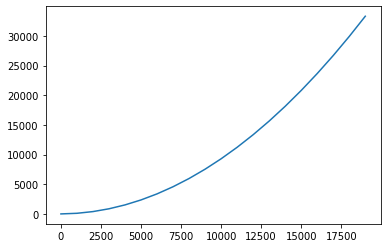

In [19]:
plt.plot(encoding_dim, model_size)

epoch 	 encoder_train 	 ally_train 	 advr_train
0 	 -1.25190508 	 0.72601831 	 0.71330523


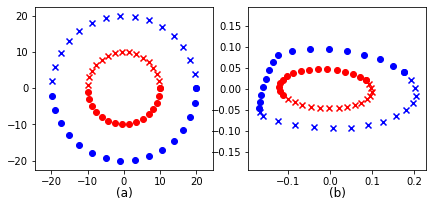

500 	 -1.27544582 	 0.71312344 	 0.71708333


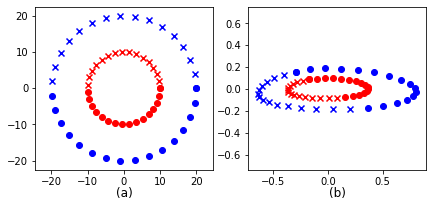

1000 	 -1.27645504 	 0.69549179 	 0.71112549


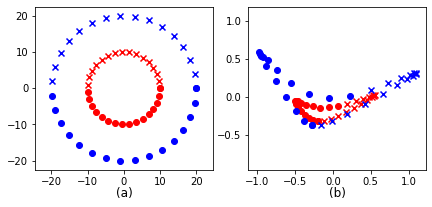

1500 	 -1.26844215 	 0.69096565 	 0.70665103


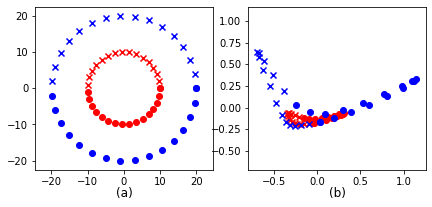

2000 	 -1.25934994 	 0.68094659 	 0.69981396


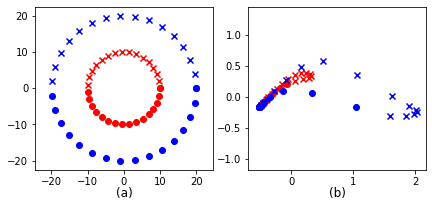

2500 	 -1.25872195 	 0.66535681 	 0.69397897


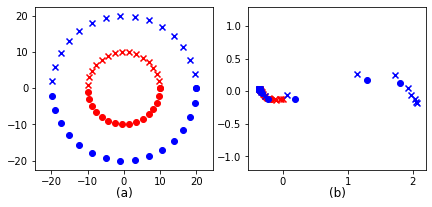

3000 	 -1.26614511 	 0.65079939 	 0.69140178


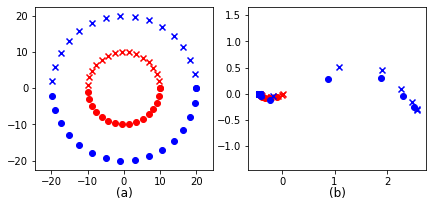

3500 	 -1.27592075 	 0.64243472 	 0.69190121


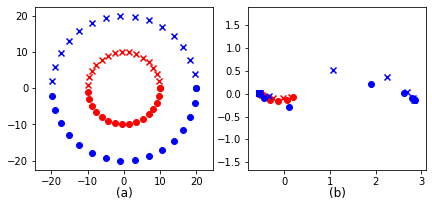

4000 	 -1.27806628 	 0.63829792 	 0.69118154


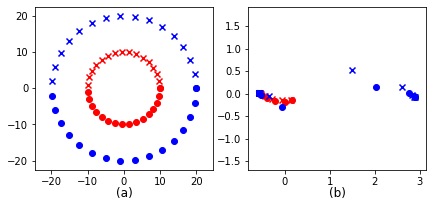

4500 	 -1.27975667 	 0.63625854 	 0.69105530


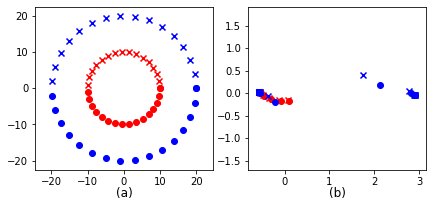

5000 	 -1.28069234 	 0.63527781 	 0.69103873


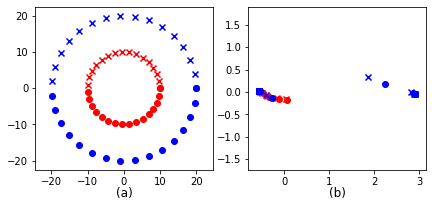

5500 	 -1.28118634 	 0.63476920 	 0.69103324


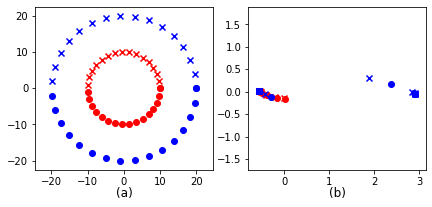

6000 	 -1.28147888 	 0.63448536 	 0.69103640


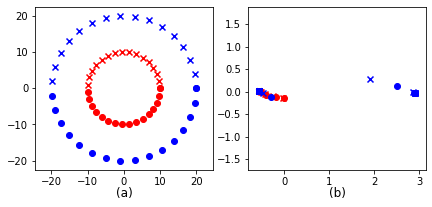

6500 	 -1.28519285 	 0.63252884 	 0.69166631


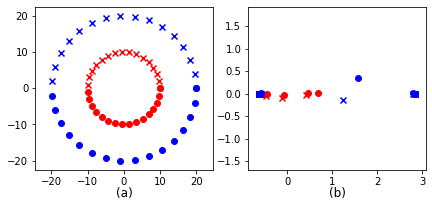

7000 	 -1.28674746 	 0.62975371 	 0.69123107


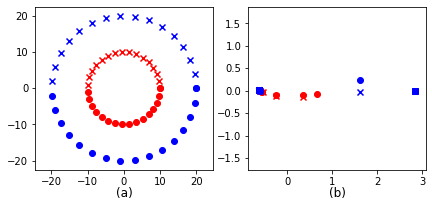

7500 	 -1.28725612 	 0.62881023 	 0.69107366


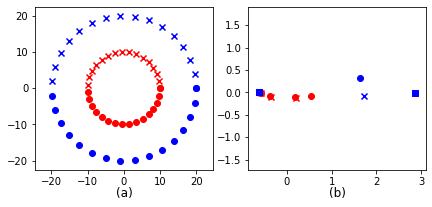

8000 	 -1.28744888 	 0.62842000 	 0.69100219


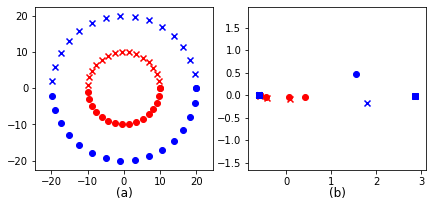

8500 	 -1.28756917 	 0.62822211 	 0.69097412


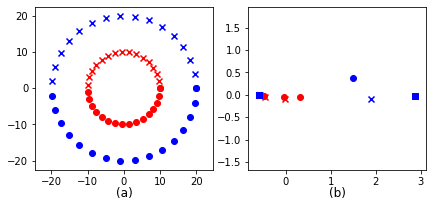

9000 	 -1.28780711 	 0.62810379 	 0.69101727


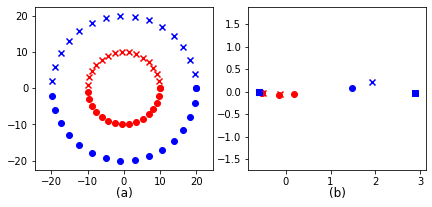

9500 	 -1.28787625 	 0.62802583 	 0.69101405


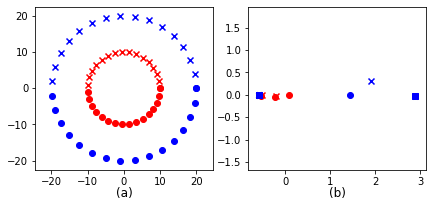

10000 	 -1.28797150 	 0.62796164 	 0.69102532


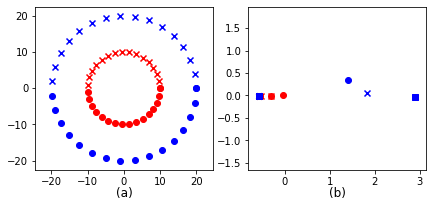

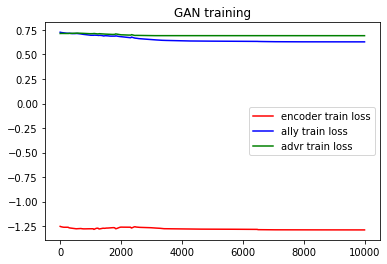

In [54]:
alpha = 1
lr_encd = 0.001
lr_ally = 0.0001
lr_advr = 0.0001
n_iter_gan = 1
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

In [24]:
alpha = 1
lr_encd = 0.001
lr_ally = 0.00001
lr_advr = 0.00001
n_iter_gan = 10001
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2

epoch 	 encoder_train 	 ally_train 	 advr_train
0 	 -0.00071341 	 0.69314730 	 0.69399118


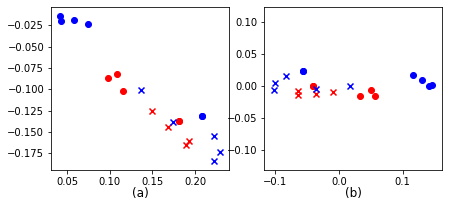

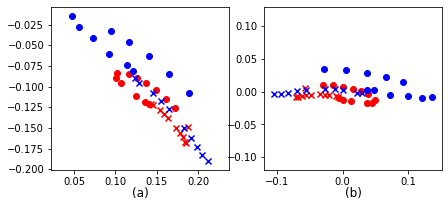

500 	 -0.01832771 	 0.69314730 	 0.71148396


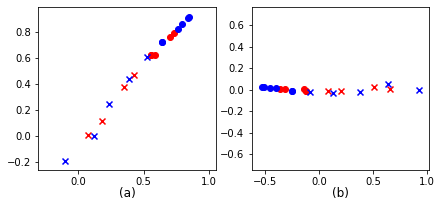

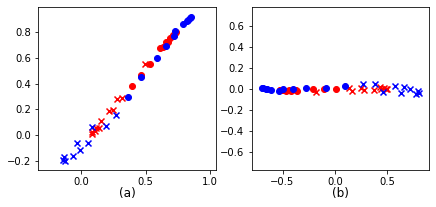

1000 	 -0.01651365 	 0.69314730 	 0.70966429


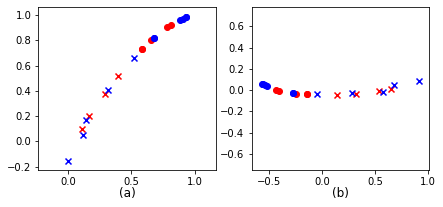

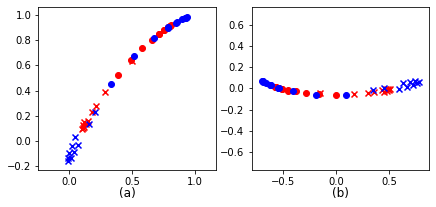

1500 	 -0.01380038 	 0.69314730 	 0.70696425


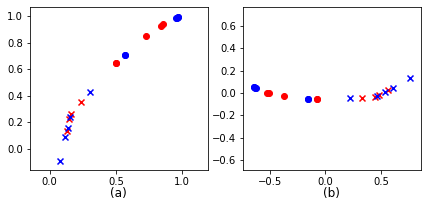

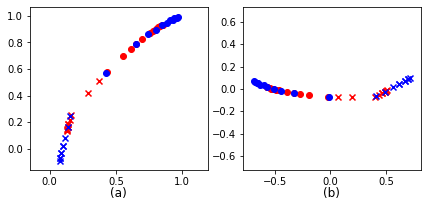

2000 	 -0.01068586 	 0.69314730 	 0.70384246


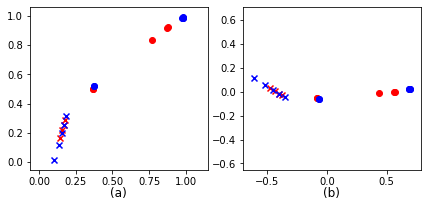

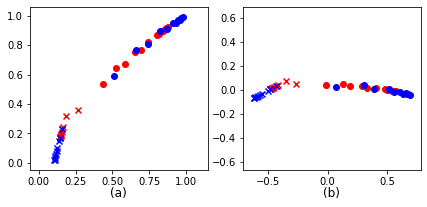

2500 	 -0.00754911 	 0.69314730 	 0.70069247


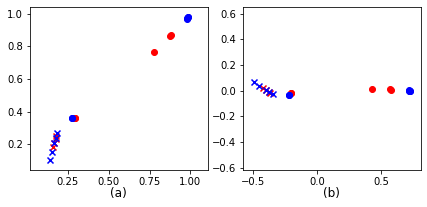

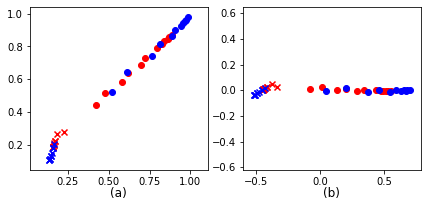

3000 	 -0.00568581 	 0.69314730 	 0.69884318


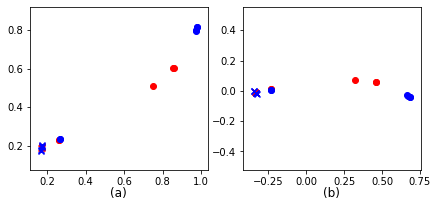

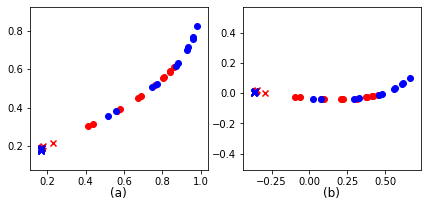

3500 	 -0.00445789 	 0.69314730 	 0.69761246


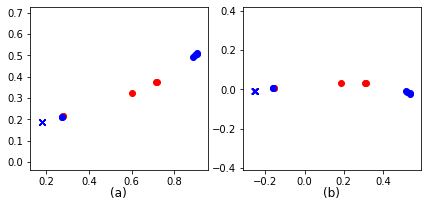

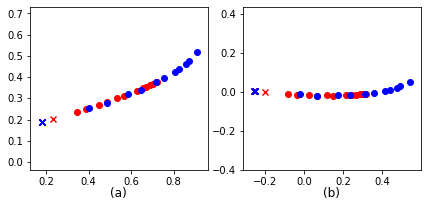

4000 	 -0.00352490 	 0.69314730 	 0.69667667


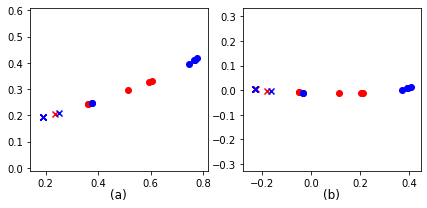

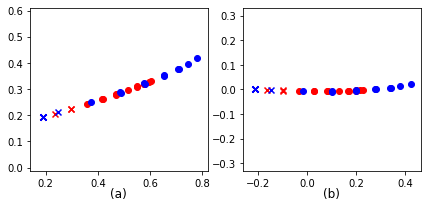

4500 	 -0.00251162 	 0.69314730 	 0.69565868


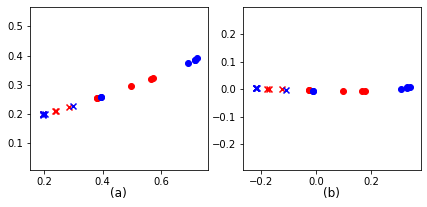

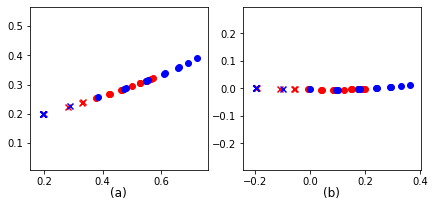

5000 	 -0.00159538 	 0.69314730 	 0.69474411


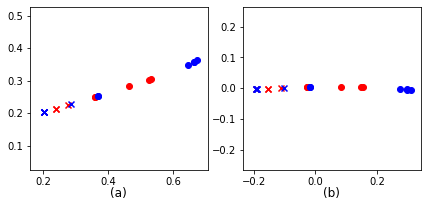

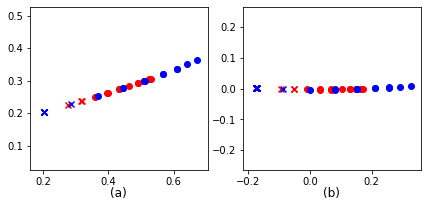

5500 	 -0.00078839 	 0.69314730 	 0.69393724


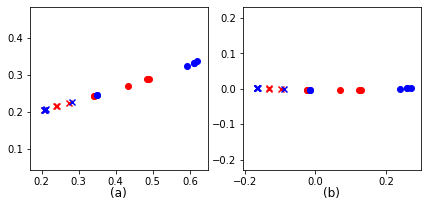

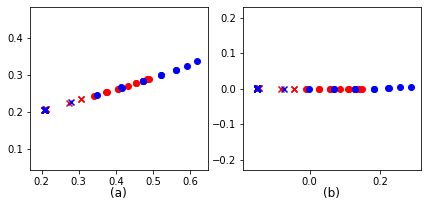

6000 	 -0.00008315 	 0.69314730 	 0.69322973


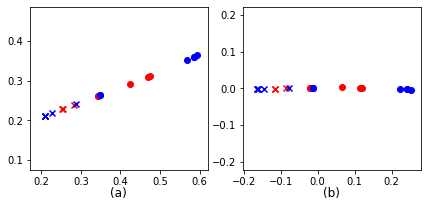

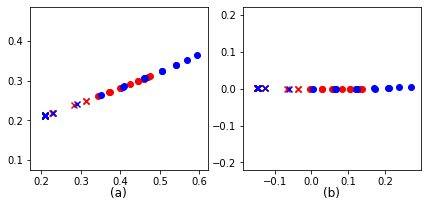

6500 	 0.00053006 	 0.69314730 	 0.69261736


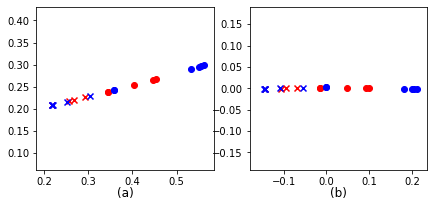

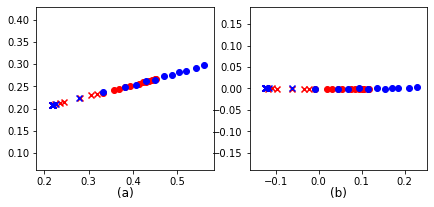

7000 	 0.00078726 	 0.69314730 	 0.69236082


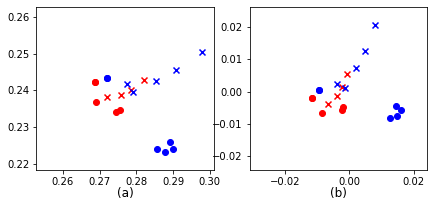

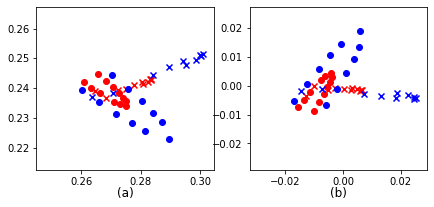

7500 	 -0.02690208 	 0.69314730 	 0.72006565


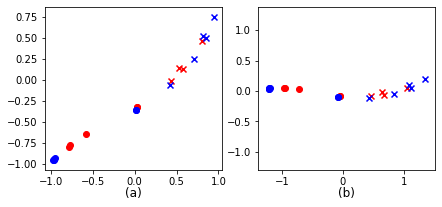

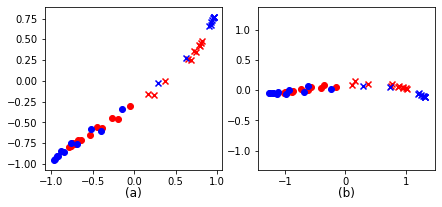

8000 	 -0.02269900 	 0.69314730 	 0.71585298


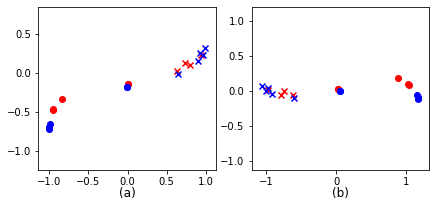

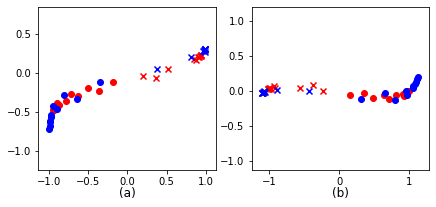

8500 	 -0.01649135 	 0.69314730 	 0.70963842


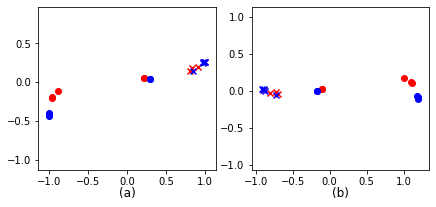

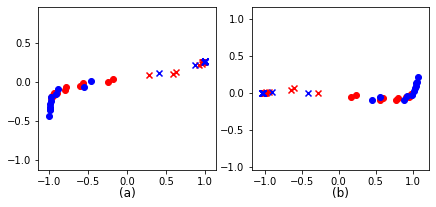

9000 	 -0.00995249 	 0.69314730 	 0.70310235


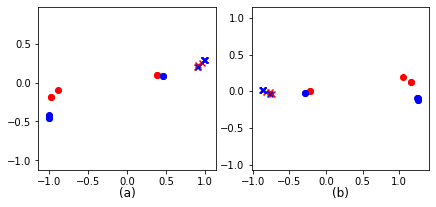

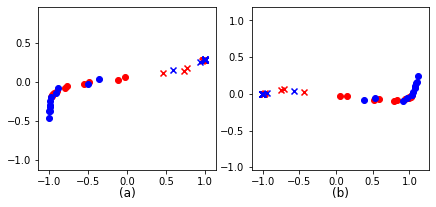

9500 	 -0.00351506 	 0.69314730 	 0.69666249


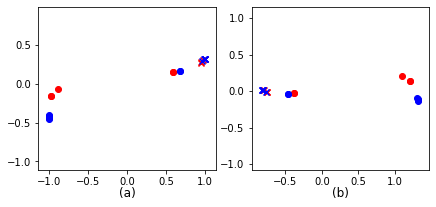

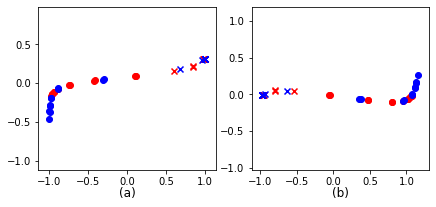

10000 	 0.00000000 	 0.69314730 	 0.69314730


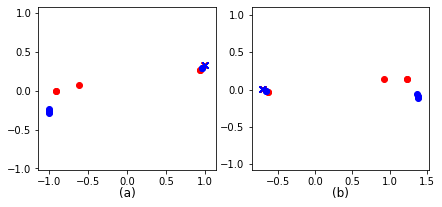

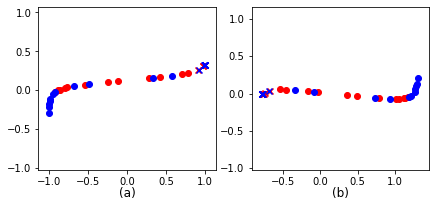

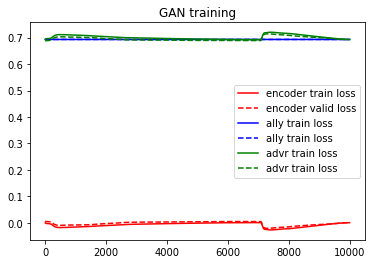

In [25]:

# X_torch = torch.Tensor(X_normalized.reshape(-1, 1))
# y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
# y_advr_torch = torch.Tensor(y_advr.reshape(-1, 1))

# X_torch_valid = torch.Tensor(X_normalized_valid[:, i].reshape(-1, 1))
# y_ally_torch_valid = torch.Tensor(y_ally_valid.reshape(-1, 1))
# y_advr_torch_valid = torch.Tensor(y_advr_valid.reshape(-1, 1))

encoder = train_privacy_gan(2, alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

In [43]:
encoder.eval()
encoded = []
encoded_valid = []
for i in range(X_normalized.shape[1]):
    X_torch = torch.Tensor(X_normalized[:, i].reshape(-1, 1))
    X_torch_valid = torch.Tensor(X_normalized_valid[:, i].reshape(-1, 1))
    encoded.append(encoder(X_torch).detach().numpy())
    encoded_valid.append(encoder(X_torch_valid).detach().numpy())

In [44]:
X = np.hstack(encoded)
X_valid = np.hstack(encoded_valid)

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_valid_pca = pca.transform(X_valid)
X_pca.shape, X_valid_pca.shape

((44, 2), (20, 2))

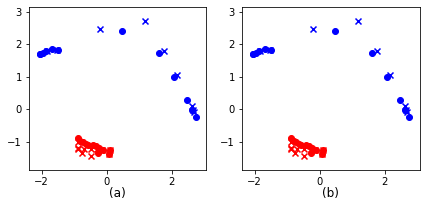

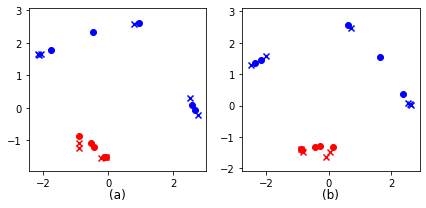

In [46]:
class_plot(X_pca, y_ally, y_advr)
class_plot(X_valid_pca, y_ally_valid, y_advr_valid)

In [ ]:
encoder.eval()
X_ganencoded = encoder(X_torch)

# Training Independently

In [ ]:
encoding_dimension = 2
encoder.eval()

In [ ]:
ally = Ally(
    input_size=encoding_dimension*4, 
    hidden_size=encoding_dimension*8, 
    output_size=y_ally_torch.shape[1])
ally_optimizer = optimizer(ally.parameters(), lr=0.001)

print("epoch \t ally_train")

ally.train()

n_iter = 10001
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_ally_torch_hat = ally(X_ganencoded)
    ally_optimizer.zero_grad()
    ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
    ally_loss.backward()
    ally_optimizer.step()
    
    if epoch%1000!=0:
        continue

    print('{} \t {:.8f}'.format(
        epoch, 
        ally_loss.item(),
    ))
    

In [ ]:
adversary = Adversary(
    input_size=encoding_dimension*4, 
    hidden_size=encoding_dimension*8, 
    output_size=y_advr_torch.shape[1])

advr_optimizer = optimizer(adversary.parameters(), lr=lr_ally)

print("epoch \t advr_train")

adversary.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_torch_hat = adversary(X_ganencoded)
    advr_optimizer.zero_grad()
    advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
    advr_loss.backward()
    advr_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_loss.item(),
    ))
    

# DP

In [ ]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

In [ ]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [ ]:
np.random.laplace(0, 1.0/100000, X_dp.shape)